<h1>Classifying European Money Denominations: Training a Pre-trained model  </h1>


<h2>Table of Contents</h2>


<p>In this lab, you will train the pre-trained model to classify the European currency. You will use the dataset object you created in the previous lab.</p>
<ul>
    <li><a href="#gen">Create Image Dataset Generator</a></li>
    <li><a href="#ques">Questions</a>
        <ol>
            <li><a href="q31">Question 3.1: Preparation</a></li>
            <li><a href="q32">Question 3.2: Train the model</a></li>
            <li><a href="q33">Question 3.3: Plot 5 Random Images with their predictions</a></li>
            <li><a href="q34">Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</a></li>
        </ol>
    </li>
    <li><a href="#save">Save the trained model</a></li>
</ul>

<p>Estimated Time Needed: <b>60 mins</b></p>
<hr>


<h2>Preparation</h2>


Download the datasets you needed for this lab.


In [1]:
import requests
import tarfile
import os

def download_and_extract(url, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the tar.gz file
    response = requests.get(url)

    # Save the downloaded file
    downloaded_file_path = os.path.join(output_dir, "data.tar.gz")
    with open(downloaded_file_path, "wb") as file:
        file.write(response.content)

    # Extract the contents of the tar.gz file
    tar = tarfile.open(downloaded_file_path, "r:gz")
    tar.extractall(output_dir)
    tar.close()

    # Delete the downloaded tar.gz file
    os.remove(downloaded_file_path)
    print(f"Data from {url} downloaded and extracted successfully!")

output_dir = "/resources/data/"
urls = [
    "https://cocl.us/DL0320EN_TRAIN_TAR_PYTORCH",
    "https://cocl.us/DL0320EN_VALID_TAR_PYTORCH",
    "https://cocl.us/DL0320EN_TEST_TAR_PYTORCH",
]

for url in urls:
    download_and_extract(url, output_dir)

Data from https://cocl.us/DL0320EN_TRAIN_TAR_PYTORCH downloaded and extracted successfully!
Data from https://cocl.us/DL0320EN_VALID_TAR_PYTORCH downloaded and extracted successfully!
Data from https://cocl.us/DL0320EN_TEST_TAR_PYTORCH downloaded and extracted successfully!


Import the PyTorch Modules needed in the lab.


In [2]:
# Import PyTorch Modules will be used in the lab

import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms
import torch.nn as nn
from torch import nn, optim
torch.manual_seed(0)

Import Non-PyTorch Modules


In [3]:
# Import Non-PyTorch Modules will be used in the lab

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

<hr>


<h2 id="gen">Create Dataset Class and Object</h2>


In this section, you use the dataset class from the last section.


The denomination, file name and the class variable for the training and validation data are stored in the following csv file.


In [4]:
# Url that contains CSV files

train_csv_file = 'https://cocl.us/DL0320EN_TRAIN_CSV'
validation_csv_file = 'https://cocl.us/DL0320EN_VALID_CSV'

The training images and validation images  are stored in the following directories.


In [5]:
# Absolute path for finding the directory contains image datasets

train_data_dir = '/resources/data/training_data_pytorch/'
validation_data_dir = '/resources/data/validation_data_pytorch/'

Use  the dataset class you created in the last lab. You can cut and paste it to here:


In [6]:
# Create Dateaset Class

class Dataset(Dataset):

    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_name = pd.read_csv(csv_file)
        self.len = self.data_name.shape[0]

    # Get Length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):
        img_name = self.data_dir + self.data_name.iloc[idx, 2]
        image = Image.open(img_name)
        y = self.data_name.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, y

Use the constructor <code>compose</code> to perform the following sequence of transformations in the order they are given, call the object <code>composed</code>


In [7]:
# Construct the composed object for transforming the image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

Create a training dataset and validation dataset object using the csv file stored in the variables the <code>train_csv_file</code> and <code>validation_csv_file</code>. The directories are stored in the variable <code>train_data_dir</code> and <code>validation_data_dir</code>. Set the parameter <code>transform</code> to the object <code>composed</code>.


In [8]:
# Create the train dataset and validation dataset

train_dataset = Dataset(transform=composed
                        ,csv_file=train_csv_file
                        ,data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)

<hr>


<h2 id="ques">Questions</h2>


<h3 id="q31">Question 3.1: Preparation</h3><b>5 points</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true.


In [10]:
# Step 1: Load the pre-trained model resnet18

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.3MB/s]


<b>Step 2</b>: The following lines of code will set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for parameter in model.parameters():
  parameter.requires_grad=False


<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 7 different bills. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [13]:
# Step 3: Re-defined the last layer

model.fc=nn.Linear(512,7)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [14]:
# Print the model (PLEASE DO NOT MODIFY THIS BOX)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h3 id="q32">Question 3.2: Train the model</h3><b>5 points</b>


<b>Step 1</b>: Create a cross entropy criterion function


In [15]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size is <i>15</i> and <i>10</i> respectively .


In [16]:
# Step 2: Create the data loader

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=15)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=10)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [18]:
# Step 3: Use the pre-defined optimizer Adam with learning rate 0.003

optimizer=torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.003)

<b>Step 4</b>: Train the model for 20 epochs, save the loss in a list as will as the accuracy on the validation data for every epoch. The entire process may take 6.5 minutes. Print the validation accuracy for each epoch during the epoch loop. Then, plot the training loss for each epoch and validation error for each epoch.


In [21]:
# Step 4: Train the model

N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

# Type your code here
for epoch in range(N_EPOCHS):
  loss_sublist=[]
  for x,y in train_loader:
    model.train()
    optimizer.zero_grad()
    z=model(x)
    loss=criterion(z,y)
    loss_sublist.append(loss.data.item())
    loss.backward()
    optimizer.step()
  loss_list.append(np.mean(loss_sublist))

  correct=0
  for x_test,y_test in validation_loader:
    model.eval()
    z=model(x_test)
    _, yhat=torch.max(z.data,1)
    correct+=(yhat==y_test).sum().item()
  accuracy=correct/n_test
  accuracy_list.append(accuracy)


<b>Step 5</b>: Plot the training loss for each iteration<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


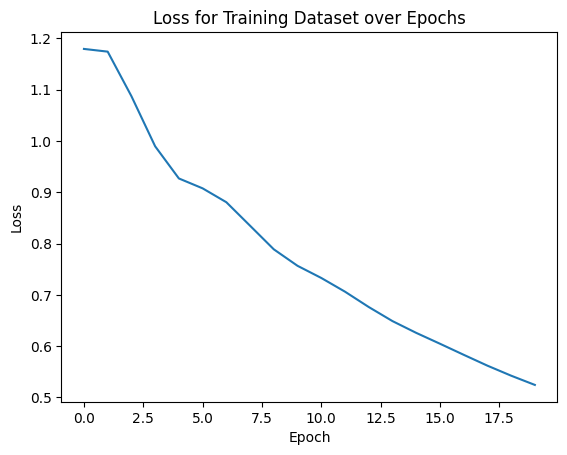

In [22]:
# Step 5: Plot the loss for training dataset

plt.figure()
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for Training Dataset over Epochs')
plt.show()

<b>Step 6</b>: Plot the validation accuracy for each epoch<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


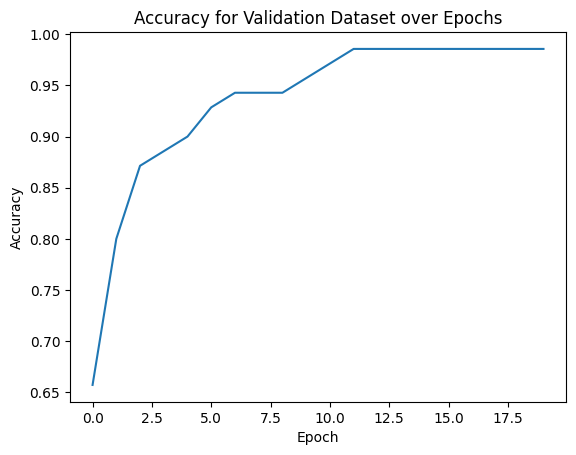

In [23]:
# Step 6: Plot the accuracy for valdiation dataset

plt.figure()
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for Validation Dataset over Epochs')
plt.show()

<h3 id="q33">Question 3.3: Plot 5 Random Images with their predictions</h3><b>5 points</b>


Create a test dataset using validation data. And, create your own <code>plot_random_image()</code> function to plot 5 random images which index is in the <code>numbers</code> list. Run the function to plot image, print the predicted label and print a string indicate whether it has been correctly classified or mis-classified.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


Image 49 is correctly classified as predicted: $100
Image 53 is correctly classified as predicted $200
Image 5 is correctly classified as predicted: $5


Image 33 is correctly classified as predicted: $50
Image 65 is correctly classified as predicted $500


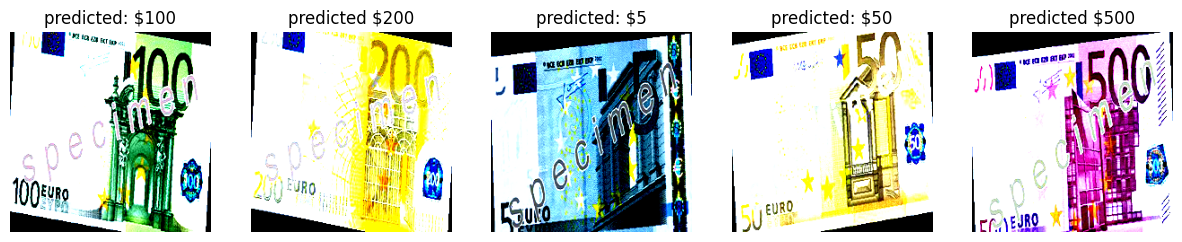

In [24]:
# Plot the images with labels

look_up = {0: 'predicted: $5'
           , 1: 'predicted: $10'
           , 2: 'predicted: $20'
           , 3: 'predicted: $50'
           , 4: 'predicted: $100'
           , 5: 'predicted $200'
           , 6: 'predicted $500'}
random.seed(0)
numbers = random.sample(range(70), 5)




def plot_random_image(model, dataset, indices, lookup):
    n = len(indices)
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 3))
    for i, ax in zip(indices, axs):
        img, label = dataset[i]
        with torch.no_grad():
            model.eval()
            img_ = img.unsqueeze(0)  # add a batch dimension
            prediction = model(img_)
            _, predicted_label = torch.max(prediction, 1)

        ax.imshow(img.permute(1, 2, 0))  # if img is a tensor with shape [C, H, W]
        ax.axis('off')
        ax.set_title(f"{lookup[predicted_label.item()]}")
        if predicted_label.item() == label:
            print(f"Image {i} is correctly classified as {lookup[label]}")
        else:
            print(f"Image {i} is mis-classified, true label is {lookup[label]}")

    plt.show()


plot_random_image(model, validation_dataset, numbers, look_up)

<h3>Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</h3><b>3 points</b>


Repeat the steps in Question 3.1, 3.2 to predict the result using <code>models.densenet121</code> model. Then, print out the last validation accuracy.


<p>Steps:</p>
<ol>
    <li>Load the pre-trained model Densenet</li>
    <li>Replace the last classification layer with only 7 classes</li>
    <li>Set the configuration (parameters)</li>
    <li>Train the model</li>
    <li>Print the last validation accuracy</li>
</ol>


Hint:
<ul>
    <li>The second last layer for this model has 1024 outputs.</li>
    <li>The last layer for <code>Densenet121</code> can be accessed by <code>model.classifier</code></li>
    <li>Use the criterion function <code>nn.CrossEntropyLoss()</code></li>
    <li>Train Batch Size: 15; Validation Batch Size: 10</li>
    <li>Optimizer: Adam with learning rate 0.003</li>
    <li>10 Epoches. Otherwise, it will take too long.</li>
</ul>


You are welcome to try any pattern of setting and find out the best result. Please name the model variable as <code>model_des</code>.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [25]:
# Use densenet121 to train the model and print out the last validation accuracy.


# Step 1: Load the pre-trained model DenseNet
model_des = models.densenet121(pretrained=True)

# Step 2: Replace the last classification layer with only 7 classes
for param in model_des.parameters():
    param.requires_grad = False

num_ftrs = model_des.classifier.in_features
model_des.classifier = nn.Linear(num_ftrs, 7)  # Assuming we have 7 classes

# Check if GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_des = model_des.to(device)

# Step 3: Set the configuration (parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_des.parameters(), lr=0.003)

# Assume train_loader and validation_loader are your data loaders
train_batch_size = 15
val_batch_size = 10
n_epochs = 10

# Step 4: Train the model
model_des.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model_des(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Step 5: Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        model_des.eval()
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_des(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch {}, Loss: {}, Validation Accuracy: {}'.format(epoch + 1, running_loss / len(train_loader), correct / total))

# Print the last validation accuracy
print('Final Validation Accuracy: {}'.format(correct / total))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 76.4MB/s]


Epoch 1, Loss: 4.062796258926392, Validation Accuracy: 0.14285714285714285
Epoch 2, Loss: 1.8548736572265625, Validation Accuracy: 0.2714285714285714
Epoch 3, Loss: 1.6543615102767943, Validation Accuracy: 0.3142857142857143
Epoch 4, Loss: 1.4544567346572876, Validation Accuracy: 0.8
Epoch 5, Loss: 0.9299565553665161, Validation Accuracy: 1.0
Epoch 6, Loss: 0.5952647507190705, Validation Accuracy: 1.0
Epoch 7, Loss: 0.37428727746009827, Validation Accuracy: 1.0
Epoch 8, Loss: 0.26898535490036013, Validation Accuracy: 0.9857142857142858
Epoch 9, Loss: 0.21990543603897095, Validation Accuracy: 0.9857142857142858
Epoch 10, Loss: 0.17552533447742463, Validation Accuracy: 0.9857142857142858
Final Validation Accuracy: 0.9857142857142858


<h2 id="#save">Save the trained model</h2>


Save the trained model for the following chapters


In [26]:
# Save the model

torch.save(model, "resnet18_pytorch.pt")
torch.save(model_des, "densenet121_pytorch.pt")